# AoU FHIR & OMOP Analysis
Information about Sync for Science and OMOP patients, and comparing the data of each.

First, define the locations of the data we wish to analyze and compare, and import the necessary modules.

In [1]:
import os
import json
import pandas as pd
import omop_analyze
import fhir_analyze
import aou_analysis

current_directory = os.getcwd()
omop_directory = "\\omop\\20190823"
fhir_directory = "\\fhir\\Participant"

*the `omop_analyze` module takes care of navigating and importing omop CSV raw data. The raw csvs are located as flat files under the `omop_directory`. The `fhir_analyze` module navigates and imports the json files per category, per patient. The patient directories are located under the `fhir_directory` location, each patient has a folder named by their `patient_id`. Each patient has `.json` files per data category. Files are named by category, as defined by the FHIR spec resource types.*

*`aou_analysis` contains all the functions for accessing and analysing the data retrieved. It mainly creates and manipulates pandas DataFrames, and counts details about data entries.*

## 1: FHIR Summary
pull in fhir data, let's find some basic data on the number of patients and number of entries retrived. `fhir_patients` is a dictionary of `patient_id`s, with deeply nested key value pairs containing all the raw data. This will be used as a basis for all following analysis.

In [2]:
fhir_patients = fhir_analyze.traverse_directory(current_directory+fhir_directory)

got 83 s4s participants


### 1 a: Histogram showing counts for each data category, across the population
For each patient, walk through all the json data entries, and count how many times each category appears. This generally shows the range of data categories in the FHIR data.

In [3]:
fhir_category_counts_df = aou_analysis.fhir_plot_category_counts(fhir_patients)
display(fhir_category_counts_df.plot(kind='box', figsize=(20,6), logy=True))

*This graph is plotted on an logarithmic y axis. While most categories have an average of 5-10 entries, lab and vital categories average in the hundreds. Patient demographics will only ever have one entry. Immunization, medication_order, and prodecures have several patients with zero entries.*

### 1 b: raw counts of histogram buckets

In [4]:
aou_analysis.export_df(fhir_category_counts_df, 'export/fhir_category_counts.csv')

*To export this data, patient data must be anonymized. The python function <> to create ranges of data values, and collected into buckets over all patients. This was put into a new DataFrame*

*The DataFrame was then exported into a csv file during the creation of this report. It can be found in the `export/` folder.*

### 1 c: Most common code systems for each data category
Each [FHIR entry](https://www.hl7.org/fhir/bundle-definitions.html#Bundle.entry) has a coding, which is a system and code pair. A full mapping of the structure of these entries can be found [in the FHIR JSON Tree](#fhir_tree). `code_system_counts` takes a list of patient entries, navigates to the coding of that type of entry via `aou_analysis.path_for_resource`, and counts the system it finds there. 

`configure_tables()` formats the output that's shown below, to prevent default behavior of hiding entries under ellipses. 

In [5]:
aou_analysis.configure_tables()
fhir_systems = aou_analysis.code_system_counts(fhir_patients)
for category, counter in fhir_systems.items():
    df = pd.DataFrame(counter.most_common())
    df.index.name = category
    df.rename(columns={0:'system', 1:'count'}, inplace=True)
    display(df)
    aou_analysis.export_df(df, 'export/fhir_systems_'+category+'.csv')

Empty DataFrame
Columns: []
Index: []

system  count
SMOKING_STATUS                               
0                     http://loinc.org    591
1               http://snomed.info/sct    427

system  count
PROBLEMS                                                   
0                             http://snomed.info/sct   3875
1                   http://hl7.org/fhir/sid/icd-9-cm   1537
2                     urn:oid:2.16.840.1.113883.6.90   1154
3         http://hl7.org/fhir/sid/icd-9-cm/diagnosis    990
4                  http://hl7.org/fhir/sid/icd-10-cm    810

system  count
MEDICATION_ORDER                                                    
0                 http://www.nlm.nih.gov/research/umls/rxnorm   5031
1                                                        None     36
2                                 http://hl7.org/fhir/sid/ndc      5

system  count
MEDICATION_STATEMENT                                                            
0                             http://www.nlm.nih.gov/research/umls/rxnorm   7737
1                     https://apis.followmyhealth.com/fhir/id/translation     23

system  count
ALLERGY_INTOLERANCE                                                    
0                    http://www.nlm.nih.gov/research/umls/rxnorm    431
1                                      http://fdasis.nlm.nih.gov    202
2                                      http://hl7.org/fhir/ndfrt    162
3                                         http://snomed.info/sct    134
4                                    http://hl7.org/fhir/sid/ndc     25
5                                                           None     25

system  count
LAB                         
0    http://loinc.org  26149

system  count
VITAL                               
0            http://loinc.org  57167
1      http://snomed.info/sct   1597

system  count
PROCEDURE                                                     
0                        http://www.ama-assn.org/go/cpt    268
1          urn:oid:1.2.840.114350.1.13.202.2.7.2.696580    122
2                                http://snomed.info/sct    119
3          urn:oid:1.2.840.114350.1.13.362.2.7.2.696580     36
4          urn:oid:1.2.840.114350.1.13.324.2.7.2.696580     28
5                        urn:oid:2.16.840.1.113883.6.14     17
6           urn:oid:1.2.840.114350.1.13.71.2.7.2.696580      8
7                                                  None      6

system  count
IMMUNIZATION                                       
0                http://hl7.org/fhir/sid/cvx   1773
1                http://hl7.org/fhir/sid/ndc    272
2             http://www.ama-assn.org/go/cpt    110

system  count
DOCUMENT                         
0         http://loinc.org    531

*The urn:oid systems are coded by a hospital's individual EPIC systems. I've contacted EPIC and the hospital systems, but I haven't been able to get any more information about these.*

### 1 d: Most common standardized codes for each data category
`aou_analysis.coding_counts` is similar to `aou_analysis.code_system_counts`, but combines similar codings via `aou_analysis.most_common_synonym` to put all codings found together into the same combined count. Codings are a list of systems and codes, often only one item in the list, but where there are multiple, that's what gets combined in `most_common_synonym`.

In [6]:
fhir_coding_results = aou_analysis.coding_counts(fhir_patients)
converter_df = pd.DataFrame([aou_analysis.converter])
for category, table in fhir_coding_results['table'].items():
    df = pd.DataFrame(table)
    df.index.name = category
    df.rename(columns={'code': 'concept_code'}, inplace=True)
    try:
        df['vocabulary_id'] = converter_df.lookup(pd.Series([0 for i in range(len(df))]), df['system'])
        df = df.join(aou_analysis.concept_table[['concept_name']], on=['concept_code', 'vocabulary_id'])
    except KeyError:
        pass
    display(df)
    aou_analysis.export_df(df, 'export/fhir_codings_'+category+'.csv')

Empty DataFrame
Columns: []
Index: []

concept_code  count                                                      display        document                  system  \
SMOKING_STATUS                                                                                                                              
0                     88031-0    237                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
1                     72166-2    234                                  Tobacco smoking status NHIS  SMOKING_STATUS        http://loinc.org   
2                   714151003    161     Environmental tobacco smoke exposure (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
3                      8663-7    109                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
4                   363905002     54     Details of alcohol drinking behavior (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
5                   224130005     24                    Household composition (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
6                     48766-0     20                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
7                   266918002     17              Tobacco smoking consumption (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
8                     73985-4     11                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
9                   228449008     11                    Frequency of exercise (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
10                  386806002     10                                 Impaired cognition (finding)  SMOKING_STATUS  http://snomed.info/sct   
11                  256235009      9                                   Exercise (qualifier value)  SMOKING_STATUS  http://snomed.info/sct   
12                   74964007      9                                      Other (qualifier value)  SMOKING_STATUS  http://snomed.info/sct   
13                  252130009      7                      Total exercise time (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
14                  363908000      7          Details of drug misuse behavior (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
15                  230125005      6                            Diet followed (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
16                  224362002      5                        Employment status (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
17                    68518-0      5                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
18                  125680007      5                           Marital status (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
19                  371422002      5      History of substance abuse (context-dependent category)  SMOKING_STATUS  http://snomed.info/sct   
20                    81228-9      5                                              Empty raw value  SMOKING_STATUS        http://loinc.org   
21                   20733006      4                             Living place (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
22                  118199002      3  Finding relating to sexuality and sexual activity (finding)  SMOKING_STATUS  http://snomed.info/sct   
23                  384759009      3                      Nutrition, function (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
24                  264362003      3                                           Home (environment)  SMOKING_STATUS  http://snomed.info/sct   
25                  160573003      2                           Alcohol intake (observable entity)  SMOKING_STATUS  http://snomed.info/sct   
26                  440652002      2         Alcohol abuse cessation 

concept_code  count                                                                                                    display  \
PROBLEMS                                                                                                                                        
0                  73211009    251                                                                                            Empty raw value   
1                 305058001    188                                                                                            Empty raw value   
2                  77386006    122                                                                       Patient currently pregnant (finding)   
3                  29857009    106                                                                                            Empty raw value   
4                  55822004     90                                                                                  Hyperlipidemia (disorder)   
5                 195967001     77                                                                                            Empty raw value   
6                    300.00     77                                                                                 Anxiety state, unspecified   
7                 228315001     72                                                                                    Binge drinker (finding)   
8                  25064002     66                                                                                            Empty raw value   
9                  42343007     63                                                                                            Empty raw value   
10                    I21.9     62                                                                   Acute myocardial infarction, unspecified   
11                271737000     54                                                                                            Empty raw value   
12                 11381005     48                                                                                            Acne (disorder)   
13                 83130006     48                                                                            Eisenmenger's defect (disorder)   
14                191268006     48                                                                                  Chronic anemia (disorder)   
15                 57054005     46                                                                                            Empty raw value   
16                      462     43                                                                                          Acute pharyngitis   
17                 68566005     41                                                                                            Empty raw value   
18                433144002     37                                                                  Chronic kidney disease stage 3 (disorder)   
19                231496004     36                                                                                       Hypomania (disorder)   
20                161625008     36                                                  History of - cardiac surgery (context-dependent category)   
21                 60125001     36                                                                Perinatal interstitial emphysema (disorder)   
22                   339.05     36                     Short lasting unilateral neuralgiform headache with conjunctival injection and tearing   
23                 53741008     36                                                                                            Empty raw value   
24                    729.1     33                                                                          Myalgia and myositis, unspecified   
25                 49436004     33                                                                  

concept_code  count  \
MEDICATION_ORDER                           
0                          308416    680   
1                          243670    195   
2                            3498    140   
3                             161    135   
4                            8640    135   
5                           23950    130   
6                            5224    120   
7                          259966    105   
8                          318272     85   
9                          202433     70   
10                         203457     65   
11                         313782     55   
12                         205770     45   
13                         866924     45   
14                         314076     45   
15                          10379     45   
16                Empty raw value     36   
17                         312617     35   
18                         727347     35   
19                           6585     35   
20                         213169     30   
21                         311354     30   
22                         198031     30   
23                        1116741     30   
24                         209387     30   
25                           3264     30   
26                         857002     26   
27                           7052     26   
28                         308191     25   
29                         309362     25   
30                        1364447     25   
31                        1293665     25   
32                        1807630     25   
33                         253174     25   
34                         429503     25   
35                           6387     23   
36                        1007534     22   
37                         855304     20   
38                         205769     20   
39                         856999     20   
40                           1191     20   
41                         212339     20   
42                           7407     20   
43                         747211     20   
44                        1292422     20   
45                         202886     20   
46                         730781     20   
47                        1807632     20   
48                        1010033     18   
49                         308135     18   
50                        1007290     18   
51                         797752     18   
52                        1007589     18   
53                          26225     17   
54                        1797907     16   
55                        1300367     16   
56                        1049640     16   
57                         153010     16   
58                         859426     15   
59                         904475     15   
60                         314200     15   
61                            723     15   
62                         219376     15   
63                         314077     15   
64                         849580     15   
65                         206913     15   
66                         311040     15   
67                         197380     15   
68                         859749     15   
69                         311034     15   
70                         859753     15   
71                        1600991     15   
72                         577962     15   
73                        1867544     15   
74                          29046     15   
75                           4603     15   
76                         727386     15   
77                         310132     15   
78                           8410     15   
79                           4955     15   
80                         152322     15   
81                           1908     15   
82                           8745     15   
83                          25480     15   
84                        1799108     13   
85                        1797933     12   
86                         197807     12   
87                        1085756     12   
88                           2180     11   
89               

concept_code  count  \
MEDICATION_STATEMENT                                                
0                                                     3498    336   
1                                                     8640    325   
2                                                      161    324   
3                                                    23950    312   
4                                                     5224    288   
5                                                   313782    194   
6                                                   202433    180   
7                                                   203457    168   
8                                                    10379    108   
9                                                   727347     96   
10                                                  209387     84   
11                                                    6585     84   
12                                                 1116741     72   
13                                                    3264     72   
14                                                    7052     61   
15                                                  429503     61   
16                                                 1807630     60   
17                                                  253174     60   
18                                                  314077     59   
19                                                    6387     56   
20                                                  856999     55   
21                                                 1007534     51   
22                                                  617310     49   
23                                                  861007     48   
24                                                 1292422     48   
25                                                  202886     48   
26                                                  730781     48   
27                                                 1807632     48   
28                                                  197381     46   
29                                                 1010033     43   
30                                                   26225     38   
31                                                 1049909     38   
32                                                 1300367     37   
33                                                  857004     37   
34                                                 1049640     37   
35                                                  153010     37   
36                                                 1797907     36   
37                                                  577962     36   
38                                                 1867544     36   
39                                                   29046     36   
40                                                    4603     36   
41                                                  727386     36   
42                                                  310132     36   
43                                                    8410     36   
44                                                    4955     36   
45                                                  152322     36   
46                                                    1908     36   
47                                                    8745     36   
48                                                   25480     36   
49                                                  311372     31   
50                                                 1085756     30   
51                                                  198440     29   
52                                                  243670     27   
53                                                 1799108     27   
54                                                  314076     26   
55                                                  308135     25   
56                                          

concept_code  count                           display              document                                       system  \
ALLERGY_INTOLERANCE                                                                                                                                
0                               2670     59                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
1                          716186003     47                  No known allergy   ALLERGY_INTOLERANCE                       http://snomed.info/sct   
2                         QE1QX6B99R     40                   Empty raw value   ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov   
3                        N0000007394     26                             LATEX   ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt   
4                          256349002     25      Peanut - dietary (substance)   ALLERGY_INTOLERANCE                       http://snomed.info/sct   
5                          111088007     25                 Latex (substance)   ALLERGY_INTOLERANCE                       http://snomed.info/sct   
6                          256259004     25                Pollen (substance)   ALLERGY_INTOLERANCE                       http://snomed.info/sct   
7                    Empty raw value     25                 FLUZONE PEDIATRIC          IMMUNIZATION                  http://hl7.org/fhir/sid/ndc   
8                        N0000008034     22   SULFA (SULFONAMIDE ANTIBIOTICS)   ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt   
9                               1202     17                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
10                              1191     17                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
11                       N0000185020     17     SHELLFISH CONTAINING PRODUCTS   ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt   
12                       N0000011281     16                       PENICILLINS   ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt   
13                              4053     15                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
14                            892620     15                          EGG YOLK   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
15                             29998     13                  OCRIPLASMIN (PF)   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
16                            225110     13    PENICILLIN G BENZATHIN,PROCAIN   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
17                               161     12                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
18                            214838     10                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
19                        3729L8MA2C     10                   Empty raw value   ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov   
20                        1564HD0N96     10                   Empty raw value   ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov   
21                         288328004     10             Bee venom (substance)   ALLERGY_INTOLERANCE                       http://snomed.info/sct   
22                              1291     10                        Bacitracin   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
23                             10831      9                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
24                             19711      7                   Empty raw value   ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm   
25                          

concept_code  count  \
LAB                           
0             2160-0    579   
1             2345-7    553   
2            17861-6    542   
3             3094-0    537   
4             2823-3    533   
5             2075-0    519   
6             2028-9    499   
7             6690-2    494   
8              789-8    489   
9             4544-3    487   
10             718-7    482   
11             786-4    471   
12             785-6    471   
13             787-2    471   
14             777-3    462   
15             788-0    453   
16            1920-8    430   
17            1751-7    420   
18            2885-2    417   
19            1975-2    411   
20            6768-6    404   
21            2951-2    398   
22            1742-6    330   
23            2571-8    304   
24           33914-3    303   
25            2085-9    294   
26            2093-3    287   
27            4548-4    280   
28           41653-7    274   
29             751-8    262   
30           48643-1    246   
31            9830-1    220   
32            3097-3    209   
33            5905-5    204   
34             771-6    201   
35             706-2    194   
36             704-7    194   
37             711-2    194   
38             713-8    192   
39             736-9    192   
40             742-7    192   
41           48642-3    185   
42             776-5    183   
43             731-0    183   
44           10466-1    173   
45            2089-1    172   
46           19048-8    172   
47             770-8    170   
48           71695-1    168   
49           58413-6    166   
50            1863-0    157   
51            2336-6    150   
52           53115-2    136   
53           77139-4    133   
54            5802-4    132   
55            5799-2    132   
56           13457-7    127   
57           43396-1    127   
58           27353-2    125   
59            5811-5    120   
60            3016-3    118   
61            6301-6    118   
62            5778-6    117   
63           26450-7    113   
64             769-0    111   
65           26478-8    109   
66            1753-3    108   
67            5797-6    108   
68           62292-8    106   
69   Empty raw value    106   
70           26485-3    101   
71            5794-3    100   
72            1744-2    100   
73           30180-4     99   
74           49024-3     93   
75           33037-3     92   
76           32623-1     89   
77           11011-4     88   
78             732-8     86   
79             743-5     86   
80             753-4     86   
81            5770-3     84   
82            5902-2     83   
83            5792-7     83   
84           64084-7     80   
85           11054-4     80   
86             705-4     75   
87             712-0     75   
88           45323-3     75   
89            5803-2     74   
90            5818-0     72   
91           46216-8     70   
92            5767-9     69   
93           46217-6     68   
94            2777-1     65   
95            1759-0     64   
96           14979-9     63   
97           19161-9     60   
98            2756-5     57   
99            2161-8     55   
100           2132-9     54   
101           2857-1     54   
102          31208-2     53   
103          26474-7     53   
104           1968-7     51   
105          11580-8     51   
106          32167-9     48   
107          10834-0     47   
108          26511-6     46   
109           3255-7     46   
110           4537-7     44   
111          14957-5     44   
112           2498-4     42   
113           2986-8     42   
114           6598-7     42   
115          14959-1     42   
116           2500-7     40   
117           3024-7     40   
118          19123-9     38   
119           5804-0     37   
120           5821-4     36   
121          XID34-9     34   
122          51584-1     33   
123            725-2     33   
124           1977-8     33   
125          13945-1     33   
126          50384-7     33   
127      

concept_code  count                                                    display document                  system vocabulary_id  \
VITAL                                                                                                                                 
0           8716-3  28222                                                Vital signs    VITAL        http://loinc.org         LOINC   
1          39156-5    713                                            Empty raw value    VITAL        http://loinc.org         LOINC   
2        225908003    356                             Pain score (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
3         86198006    160                          Influenza vaccination (procedure)    VITAL  http://snomed.info/sct        SNOMED   
4          19928-1    125                                            Empty raw value    VITAL        http://loinc.org         LOINC   
5           8327-9    113                                            Empty raw value    VITAL        http://loinc.org         LOINC   
6          41904-4    100                                            Empty raw value    VITAL        http://loinc.org         LOINC   
7           8478-0     93                                            Empty raw value    VITAL        http://loinc.org         LOINC   
8           3151-8     90                                            Empty raw value    VITAL        http://loinc.org         LOINC   
9         70878000     84                 Electrocardiogram, rhythm (regime/therapy)    VITAL  http://snomed.info/sct        SNOMED   
10         76536-2     68                                            Empty raw value    VITAL        http://loinc.org         LOINC   
11          8277-6     55                                            Empty raw value    VITAL        http://loinc.org         LOINC   
12          8280-0     31                                            Empty raw value    VITAL        http://loinc.org         LOINC   
13         56074-8     15                                            Empty raw value    VITAL        http://loinc.org         LOINC   
14          8480-6     15                                    blood pressure systolic    VITAL        http://loinc.org         LOINC   
15          8462-4     15                                   blood pressure diastolic    VITAL        http://loinc.org         LOINC   
16       425401001     12             Pain intensity rating scale (assessment scale)    VITAL  http://snomed.info/sct        SNOMED   
17          3140-1      6                                            Empty raw value    VITAL        http://loinc.org         LOINC   
18          8455-8      6                                            Empty raw value    VITAL        http://loinc.org         LOINC   
19          8461-6      6                                            Empty raw value    VITAL        http://loinc.org         LOINC   
20       413605002      5  Average home diastolic blood pressure (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
21       413606001      5   Average home systolic blood pressure (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
22         6942003      5                 Level of consciousness (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
23         41653-7      5                                            Empty raw value    VITAL        http://loinc.org         LOINC   
24       364533002      5                          Color of skin (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
25         41982-0      1                                            Empty raw value    VITAL        http://loinc.org         LOINC   
26       406524005      1               Reason for visit diagnosis (qualifier value)    VITAL  http://snomed.info/sct        SNOMED   

                                                 concept_name  
VITAL                     

concept_code  count                                                                             display   document  \
PROCEDURE                                                                                                                          
0                    86580     52                                                              PR TB INTRADERMAL TEST  PROCEDURE   
1                 10224242     41                                                                   GENERAL PROCEDURE  PROCEDURE   
2                 90412006     25                                               Colonoscope, device (physical object)  PROCEDURE   
3                    69210     19                                                          PR REMOVE IMPACTED EAR WAX  PROCEDURE   
4                    G0121     17                                                     PR COLON CA SCRN NOT HI RSK IND  PROCEDURE   
5                    93351     15                                  PR ECHO HEART XTHORACIC, STRESS/REST, W CONTIN ECG  PROCEDURE   
6                    93010     15                                      ELECTROCARDIOGRAM, ROUTINE W/AT LEAST 12 LEADS  PROCEDURE   
7                   128454     13                                                                SPIROMETRY - NURSING  PROCEDURE   
8                    92133     12                                      PR COMPUTERIZED OPHTHALMIC IMAGING OPTIC NERVE  PROCEDURE   
9                    42821     12                                     Tonsillectomy and adenoidectomy; age 12 or over  PROCEDURE   
10                   44960     12         Appendectomy; for ruptured appendix with abscess or generalized peritonitis  PROCEDURE   
11                10232048     11                                                                     INTRAOP-NURSING  PROCEDURE   
12                   92083     10                                                       PR VISUAL FIELD EXAM,EXTENDED  PROCEDURE   
13                10241731     10                                                    ARTHROCENTESIS - JOINT INJECTION  PROCEDURE   
14                10232050     10                                                                                PACU  PROCEDURE   
15                10232053     10                                                                 OR-PT PROFILE-ADULT  PROCEDURE   
16                10232049     10                                                                       PREOP-NURSING  PROCEDURE   
17                73761001      8                                                                  COLONOSCOPY REPORT  PROCEDURE   
18                  224543      8                                                                         STRESS ECHO  PROCEDURE   
19                   44385      8                                    PR NDSC EVAL INTSTINAL POUCH DX W/COLLJ SPEC SPX  PROCEDURE   
20                  103300      8                                                                     VASCULAR REPORT  PROCEDURE   
21               428251008      7                                                                     Empty raw value  PROCEDURE   
22               284181007      7                                                                     Empty raw value  PROCEDURE   
23                  106252      7                                                           AMBULATORY BLOOD PRESSURE  PROCEDURE   
24                50731006      6                                                                   OUTSIDE PROCEDURE  PROCEDURE   
25                   78452      6                                                HC MYOCARDIAL SPECT MULTIPLE STUDIES  PROCEDURE   
26                59127000      6                                                                       APNEA MONITOR  PROCEDURE   
27         Empty raw value      6                                                                        Appendectomy  PROCEDURE   
28                   92557      6                     

concept_code  count                                                                  display      document  \
IMMUNIZATION                                                                                                              
0                     140    172                                                          Empty raw value  IMMUNIZATION   
1                     115    136                                                          Empty raw value  IMMUNIZATION   
2                      88    126                                                                INFLUENZA  IMMUNIZATION   
3                      98    104                                                      TUBERCULIN PPD TEST  IMMUNIZATION   
4                     150    100                                                          Empty raw value  IMMUNIZATION   
5                     139     57                                        Td(adult) unspecified formulation  IMMUNIZATION   
6                     110     50                                                          Empty raw value  IMMUNIZATION   
7                      08     49                                                          Empty raw value  IMMUNIZATION   
8                      10     47                                                                    POLIO  IMMUNIZATION   
9                      45     46                                                          Empty raw value  IMMUNIZATION   
10                     20     44                                                                     DTAP  IMMUNIZATION   
11                    141     43                                                          Empty raw value  IMMUNIZATION   
12                     21     41                                                          Empty raw value  IMMUNIZATION   
13                     33     38                                                          Empty raw value  IMMUNIZATION   
14                    135     31                                                          Empty raw value  IMMUNIZATION   
15                     03     30                                                          Empty raw value  IMMUNIZATION   
16                    160     30                                                        INFLUENZA (WHOLE)  IMMUNIZATION   
17                    121     30                               ZOSTAVAX - ZOSTER VACCINE LIVE 19,400 UNIT  IMMUNIZATION   
18                     62     30  HPV (HUMAN PAPILLOMA VIRUS), QUADRIVALENT VACCINE (PRIOR TO 06/01/2015)  IMMUNIZATION   
19                  90713     30                                                 IPOL, inactivated, SQ/IM  IMMUNIZATION   
20                    133     27                                                          Empty raw value  IMMUNIZATION   
21                     02     26                                                                      OPV  IMMUNIZATION   
22                     52     25                                               HEPATITIS A, ADULT VACCINE  IMMUNIZATION   
23                    107     25                                                        DTaP (Historical)  IMMUNIZATION   
24                     43     23                                                          Empty raw value  IMMUNIZATION   
25                     09     21                                                          Empty raw value  IMMUNIZATION   
26                     85     21                                                 HEPATITIS A, UNSPECIFIED  IMMUNIZATION   
27                     87     20                                                          Empty raw value  IMMUNIZATION   
28                  90700     20                                                                     DTap  IMMUNIZATION   
29                     05     17                                                                  MEASLES  IMMUNIZATION   
30                     91     16                                         TYPH

concept_code  count                        display  document            system vocabulary_id             concept_name
DOCUMENT                                                                                                                      
0             11506-3    389     Subsequent evaluation note  DOCUMENT  http://loinc.org         LOINC            Progress note
1             34133-9    142  Summarization of Episode Note  DOCUMENT  http://loinc.org         LOINC  Summary of episode note

In [7]:
# Display list of most_common_synonyms, with display names attached, to make sure they're reasonable synonyms.
for category, table in fhir_coding_results['synonyms'].items():
    print("\n", category)
    aou_analysis.print_synonym_sets(table, fhir_coding_results['display'])


 PATIENT_DEMOGRAPHICS

 SMOKING_STATUS
http://loinc.org 72166-2 => ['Tobacco smoking status NHIS', 'Tobacco use and exposure (observable entity)']

 PROBLEMS
urn:oid:2.16.840.1.113883.6.90 E78.01 => ['Hypercholesteremia', 'Hypercholesteremia', 'Pure hypercholesterolemia (disorder)', 'Hypercholesterolemia (disorder)', 'Hyperlipidemia type II', 'Familial hypercholesterolemia (disorder)']
http://snomed.info/sct 35253001 => ['Attention deficit hyperactivity disorder, predominantly inattentive type', 'ADD (attention deficit disorder)', 'Attention deficit hyperactivity disorder, predominantly inattentive type (disorder)', 'Adult attention deficit hyperactivity disorder (disorder)', 'Attention deficit hyperactivity disorder (ADHD), inattentive type, moderate, in partial remission', 'Attention deficit hyperactivity disorder (ADHD), inattentive type, moderate, in partial remission']
http://snomed.info/sct 399068003 => ['Malignant tumor of prostate (disorder)', 'Malignant neoplasm of prostate',

http://www.nlm.nih.gov/research/umls/rxnorm 723 => ['AMOXICILLIN', 'amoxicillin 500 mg oral tablet', 'AMOXICILLIN']
http://www.nlm.nih.gov/research/umls/rxnorm 4053 => ['ERYTHROMYCIN BASE', 'Empty raw value']
http://fdasis.nlm.nih.gov 4NRT660KJQ => ['SULFACETAMIDE SODIUM', 'SULFACETAMIDE SODIUM']
http://www.nlm.nih.gov/research/umls/rxnorm 83366 => ['ATORVASTATIN', 'ATORVASTATIN']
http://fdasis.nlm.nih.gov EOR26LQQ24 => ['EZETIMIBE', 'EZETIMIBE', 'EZETIMIBE']
http://fdasis.nlm.nih.gov 207ZZ9QZ49 => ['METHYLPHENIDATE', 'METHYLPHENIDATE', 'METHYLPHENIDATE']
http://www.nlm.nih.gov/research/umls/rxnorm 38400 => ['ATOMOXETINE', 'ATOMOXETINE']
http://hl7.org/fhir/ndfrt N0000005842 => ['SIMVASTATIN', 'SIMVASTATIN', 'SIMVASTATIN']
http://fdasis.nlm.nih.gov QUC7NX6WMB => ['SERTRALINE', 'SERTRALINE']
http://fdasis.nlm.nih.gov GRZ5RCB1QG => ['VENLAFAXINE', 'VENLAFAXINE']
http://fdasis.nlm.nih.gov R6DXU4WAY9 => ['ESOMEPRAZOLE MAGNESIUM', 'ESOMEPRAZOLE MAGNESIUM']
http://fdasis.nlm.nih.gov IHS69L0Y

*Not all codings have display names associated in the data entry. The lab category is very consistent, the vital category needs better detail on the basic "Vital signs 8716-3" entry.*

### 1 e: Count of valid vs invalid codes per data category

In [28]:
raw_codes_df = pd.DataFrame(fhir_coding_results['display']).transpose()
raw_codes_df.rename(columns={'code': 'concept_code'}, inplace=True)
raw_codes_df['vocabulary_id'] = converter_df.lookup(pd.Series([0 for i in range(len(raw_codes_df))]), raw_codes_df['system'])
concept_table = aou_analysis.concept_table[['concept_name']]
df = pd.merge(raw_codes_df, concept_table, how='left', on=['concept_code', 'vocabulary_id'])
gk = df.groupby('document')
grouped_valid_invalid = {}
for category in gk:
    category_df = pd.DataFrame(category[1])
    display(category_df)
    invalid_count = category_df['concept_name'].isna().sum(axis=0)
    grouped_valid_invalid[category[0]] = {
        "unique invalid": invalid_count,
        "unique valid": len(category_df) - invalid_count,
        "total invalid": 0,
        "total valid": 0,
    }
vi_df = pd.DataFrame(grouped_valid_invalid).transpose()
aou_analysis.export_df(vi_df, 'export/fhir_valid_invalid.csv')
display(vi_df)

concept_code                           display             document                                       system    vocabulary_id  \
14        716186003                  No known allergy  ALLERGY_INTOLERANCE                       http://snomed.info/sct           SNOMED   
586            6979                   MINOCYCLINE HCL  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
587      0020414E5U                   MINOCYCLINE HCL  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
588     N0000178938                   MINOCYCLINE HCL  ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt             None   
589            1202                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
590      50VV3VW0TI                          ATENOLOL  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
591     N0000006639                          ATENOLOL  ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt             None   
592           10180                  SULFAMETHOXAZOLE  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
593      JE42381TNV                  SULFAMETHOXAZOLE  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
594     N0000006904                  SULFAMETHOXAZOLE  ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt             None   
1121           5640                         IBUPROFEN  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1145          10831                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1168           1191                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1224            161                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1227          21949                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1233          35827                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1236           7052                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1280          29046                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1286           8640                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1343          11289                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1384           2670                   Empty raw value  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1440     Q830PW7520                           CODEINE  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
1441         891658                            PEANUT  ALLERGY_INTOLERANCE  http://www.nlm.nih.gov/research/umls/rxnorm           RxNorm   
1442     QE1QX6B99R                   Empty raw value  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
1443    N0000007394                             LATEX  ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt             None   
1444    N0000006691                           CODEINE  ALLERGY_INTOLERANCE                    http://hl7.org/fhir/ndfrt             None   
1445     R16CO5Y76E                           ASPIRIN  ALLERGY_INTOLERANCE                    http://fdasis.nlm.nih.gov             None   
1446    N0000006582                           ASPIRIN  ALLERGY_INTOLERANCE             

concept_code                                                                                                                  display  \
1            4119  This response includes information available to the authorized user at the time of the request. It may not contain t...   
81        34133-9                                                                                            Summarization of Episode Note   
82           4119  This response includes information available to the authorized user at the time of the request. It may not contain t...   
155          4122                                                                   An unknown query parameter was supplied by the client.   
252       11506-3                                                                                               Subsequent evaluation note   
736          4119  This response includes information available to the authorized user at the time of the request. It may not contain t...   
737          4119  This response includes information available to the authorized user at the time of the request. It may not contain t...   
738          4119  This response includes information available to the authorized user at the time of the request. It may not contain t...   
1097         4122                                                                   An unknown query parameter was supplied by the client.   
1098         4122                                                                   An unknown query parameter was supplied by the client.   
1222         4122                                                                   An unknown query parameter was supplied by the client.   
1394         4122                                                                   An unknown query parameter was supplied by the client.   
1730         4101                                                                                     Resource request returns no results.   

      document                                        system vocabulary_id             concept_name  
1     DOCUMENT   urn:oid:1.2.840.114350.1.13.71.2.7.2.657369          None                      NaN  
81    DOCUMENT                              http://loinc.org         LOINC  Summary of episode note  
82    DOCUMENT  urn:oid:1.2.840.114350.1.13.362.2.7.2.657369          None                      NaN  
155   DOCUMENT  urn:oid:1.2.840.114350.1.13.362.2.7.2.657369          None                      NaN  
252   DOCUMENT                              http://loinc.org         LOINC            Progress note  
736   DOCUMENT  urn:oid:1.2.840.114350.1.13.324.2.7.2.657369          None                      NaN  
737   DOCUMENT  urn:oid:1.2.840.114350.1.13.202.2.7.2.657369          None                      NaN  
738   DOCUMENT  urn:oid:1.2.840.114350.1.13.232.2.7.2.657369          None                      NaN  
1097  DOCUMENT   urn:oid:1.2.840.114350.1.13.71.2.7.2.657369          None                      NaN  
1098  DOCUMENT  urn:oid:1.2.840.114350.1.13.324.2.7.2.657369          None                      NaN  
1222  DOCUMENT  urn:oid:1.2.840.114350.1.13.232.2.7.2.657369          None                      NaN  
1394  DOCUMENT  urn:oid:1.2.840.114350.1.13.202.2.7.2.657369          None                      NaN  
1730  DOCUMENT  urn:oid:1.2.840.114350.1.13.202.2.7.2.657369          None                      NaN

concept_code                                                                  display      document  \
73                150                                                          Empty raw value  IMMUNIZATION   
74                115                                                          Empty raw value  IMMUNIZATION   
75                137                                                    HUMAN PAPILLOMA VIRUS  IMMUNIZATION   
76                 08                                                          Empty raw value  IMMUNIZATION   
77                114                                                          Empty raw value  IMMUNIZATION   
78             242001                                                             49281-417-58  IMMUNIZATION   
79             250934                                                             49281-418-88  IMMUNIZATION   
80               4117                                           CVX code for vaccine not found  IMMUNIZATION   
247               135                                                          Empty raw value  IMMUNIZATION   
248            295360                                                             49281-399-88  IMMUNIZATION   
249               133                                                          Empty raw value  IMMUNIZATION   
250            191782                                                             0005-1971-01  IMMUNIZATION   
251            306144                                                             49281-401-65  IMMUNIZATION   
433                91                                         TYPHOID, UNSPECIFIED FORMULATION  IMMUNIZATION   
434                03                                                          Empty raw value  IMMUNIZATION   
435               141                                                          Empty raw value  IMMUNIZATION   
436               104                                                              HEP A/HEP B  IMMUNIZATION   
437                10                                                                    POLIO  IMMUNIZATION   
438               127                                                  Novel influenza-H1N1-09  IMMUNIZATION   
439                88                                                                INFLUENZA  IMMUNIZATION   
730               140                                                          Empty raw value  IMMUNIZATION   
731                45                                                          Empty raw value  IMMUNIZATION   
732               128            NOVEL INFLUENZA-H1N1-09, ALL FORMULATIONS (BETWEEN 2009-2010)  IMMUNIZATION   
733                33                                                          Empty raw value  IMMUNIZATION   
734            306252                                                             58160-907-52  IMMUNIZATION   
735            232160                                                             58160-842-01  IMMUNIZATION   
1096             4101                                     Resource request returns no results.  IMMUNIZATION   
1491  Empty raw value                                                        FLUZONE PEDIATRIC  IMMUNIZATION   
1570              109                                    PNEUMOCOCCAL, UNSPECIFIED FORMULATION  IMMUNIZATION   
1571              112                                  TETANUS TOXOID, UNSPECIFIED FORMULATION  IMMUNIZATION   
1572               09                                                          Empty raw value  IMMUNIZATION   
1573              187                                                          Empty raw value  IMMUNIZATION   
1574              125                                                   H1N1 INFLUENZA (NASAL)  IMMUNIZATION   
1575              139                                        Td(adult) unspecified formulation  IMMUNIZATION   
1576               26                                                                  ch

concept_code                                                                                                                  display  \
15             2345-7                                                                                 Glucose [Mass/volume] in Serum or Plasma   
16             2951-2                                                                                 Sodium [Moles/volume] in Serum or Plasma   
17             2823-3                                                                              Potassium [Moles/volume] in Serum or Plasma   
18             2075-0                                                                               Chloride [Moles/volume] in Serum or Plasma   
19             2028-9                                                                  Carbon dioxide, total [Moles/volume] in Serum or Plasma   
20             3094-0                                                                           Urea nitrogen [Mass/volume] in Serum or Plasma   
21             2160-0                                                                              Creatinine [Mass/volume] in Serum or Plasma   
22            17861-6                                                                                 Calcium [Mass/volume] in Serum or Plasma   
23             1975-2                                                                         Bilirubin.total [Mass/volume] in Serum or Plasma   
24             2093-3                                                                             Cholesterol [Mass/volume] in Serum or Plasma   
25             2885-2                                                                                 Protein [Mass/volume] in Serum or Plasma   
26             1751-7                                                                                 Albumin [Mass/volume] in Serum or Plasma   
27             1920-8                                                Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma   
28             1742-6                                                  Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma   
29             6768-6                                                      Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma   
30             3097-3                                                                 Urea nitrogen/Creatinine [Mass Ratio] in Serum or Plasma   
31             2571-8                                                                            Triglyceride [Mass/volume] in Serum or Plasma   
32              777-3                                                                         Platelets [#/volume] in Blood by Automated count   
33             9830-1                                                                                                          Empty raw value   
34            10834-0                                                                           Globulin [Mass/volume] in Serum by calculation   
35             1759-0                                                                         Albumin/Globulin [Mass Ratio] in Serum or Plasma   
36            13457-7                                                       Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation   
37             2085-9                                                                      Cholesterol in HDL [Mass/volume] in Serum or Plasma   
38             4544-3                                                                 Hematocrit [Volume Fraction] of Blood by Automated count   
39              718-7                                                                                        Hemoglobin [Mass/volume] in Blood   
40              786-4                                                                                    MCHC [Mass/volume] by Automated count   
41              785-6                                              

concept_code                                                                 display          document  \
159        314200                                   Protonix 40 mg delayed release tablet  MEDICATION_ORDER   
165       1364447                                                Eliquis 5 mg oral tablet  MEDICATION_ORDER   
169        197361                                             amLODIPine 5 mg oral tablet  MEDICATION_ORDER   
170        318272                                     aspirin 81 mg oral tablet, chewable  MEDICATION_ORDER   
172        308416                                    Aspir 81 oral delayed release tablet  MEDICATION_ORDER   
173        309362                                           clopidogrel 75 mg oral tablet  MEDICATION_ORDER   
356        859426                                                Crestor 5 mg oral tablet  MEDICATION_ORDER   
364        205770                                                Cipro 500 mg oral tablet  MEDICATION_ORDER   
366        197807                                            ibuprofen 800 mg oral tablet  MEDICATION_ORDER   
377       1020026                                                ZyrTEC 10 mg oral tablet  MEDICATION_ORDER   
379        243670                                               aspirin 81 mg oral tablet  MEDICATION_ORDER   
557        212033                                            Ascriptin 325 mg oral tablet  MEDICATION_ORDER   
559       1115005                                     docusate sodium 100 mg oral capsule  MEDICATION_ORDER   
564        828348                                       cyclobenzaprine 10 mg oral tablet  MEDICATION_ORDER   
568        311353                                           lisinopril 2.5 mg oral tablet  MEDICATION_ORDER   
575        311040                       insulin aspart 100 units/mL subcutaneous solution  MEDICATION_ORDER   
578        310429                                            furosemide 20 mg oral tablet  MEDICATION_ORDER   
580        835603                                              traMADol 50 mg oral tablet  MEDICATION_ORDER   
1099       866514                                                 metoprolol 50 mg tablet  MEDICATION_ORDER   
1100       197433                                           calcium acetate 667 mg tablet  MEDICATION_ORDER   
1101       856987                            acetaminophen-HYDROcodone 300 mg-5 mg tablet  MEDICATION_ORDER   
1102       884173                                                 cloNIDine 0.1 mg tablet  MEDICATION_ORDER   
1103       197582                                               dexamethasone 4 mg tablet  MEDICATION_ORDER   
1104       214182                                                            Lortab 5/500  MEDICATION_ORDER   
1105       311288                                                    Keppra 250 mg tablet  MEDICATION_ORDER   
1106       207287                                               Flagyl 250 mg oral tablet  MEDICATION_ORDER   
1107      1649990                                                             doxycycline  MEDICATION_ORDER   
1108       859747                                          rosuvastatin 10 mg oral tablet  MEDICATION_ORDER   
1110       198335                                         Bactrim DS 800 mg-160 mg tablet  MEDICATION_ORDER   
1111       904475                                           pravastatin 40 mg oral tablet  MEDICATION_ORDER   
1112       309114                                               cephalexin 500 mg capsule  MEDICATION_ORDER   
1113       617296                            amoxicillin-clavulanate 500 mg-125 mg tablet  MEDICATION_ORDER   
1114       833213                                  Dexilant 60 mg delayed release capsule  MEDICATION_ORDER   
1115       197454                                                cephalexin 500 mg tablet  MEDICATION_ORDER   
1116       205323                                                 CeleBREX 200 mg capsule  MEDICATION_ORDER   
1117     

concept_code  \
8                                   581417   
9                                     4301   
10                                  311372   
11                                  313096   
12                                  748800   
13                                  861223   
156                                 144450   
157                                1797907   
158                                 198440   
160                                1923422   
161                                 259255   
162                                 863669   
163                                 351172   
164                                 898367   
166                                 312935   
167                                 898719   
168                                 310410   
171                                 198641   
174                                 310798   
347                                 859424   
348                                 203576   
349                                 312615   
350                                 855174   
351                                 855172   
352                                1797933   
353                                 864679   
354                                 261315   
355                                 807219   
357                                 260330   
358                                1650142   
359                                 259132   
360                                 617318   
361                                1007534   
362                                 197700   
363                                 312055   
365                                 114883   
367                                1041518   
368                                 834102   
369                                 856903   
370                                   6694   
371                                  41126   
372                                 153189   
373                                 287617   
374                                 218128   
375                                 203302   
376                                1797849   
378                                 210273   
380                                 310273   
381                                 978010   
558                                 636522   
560                                 282402   
561                                 646333   
562                                 866427   
563                                 966248   
565                                 857336   
566                                 897122   
567                                 596934   
569                                 993466   
570                                 317110   
571                                 993557   
572                                 310672   
573                                 203088   
574                                 310434   
576                                1648211   
577                                 198039   
579                                1986825   
581                                 282465   
582                                 617311   
583                                 904431   
584                                 198211   
585                                1648755   
1109                                197381   
1136                                314077   
1223                               1863605   
1225                                  1596   
1226                                  1897   
1228                                  3498   
1229                                 82003   
1230                                 67108   
1231                                  4018   
1232                                404280   
1234                                  6581   
1235                                  6918   
1237                                 26225   
1238                                  7804   
1239                                198776   
1240                        

concept_code                                                                                                                  display  \
2                 272.0                                                                                                       Hypercholesteremia   
3                E78.00                                                                                                       Hypercholesteremia   
4              13644009                                                                                          Hypercholesterolemia (disorder)   
5                314.00                                                 Attention deficit hyperactivity disorder, predominantly inattentive type   
6                 F98.8                                                                                         ADD (attention deficit disorder)   
7             444613000                                                                Adult attention deficit hyperactivity disorder (disorder)   
83                  185                                                                                           Malignant neoplasm of prostate   
84                  C61                                                                                           Malignant neoplasm of prostate   
85            399068003                                                                                   Malignant tumor of prostate (disorder)   
86                401.1                                                                                                      Benign hypertension   
87                  I10                                                                                                      Benign hypertension   
88              1201005                                                                                 Benign essential hypertension (disorder)   
89            267432004                                                                                     Pure hypercholesterolemia (disorder)   
90               715.16                                                                                     Primary osteoarthritis of right knee   
91               M17.11                                                                                     Primary osteoarthritis of right knee   
92      323321000119100                                                                            Osteoarthritis of right knee joint (disorder)   
93               530.81                                                                                   Laryngitis from reflux of stomach acid   
94                K21.9                                                                                   Laryngitis from reflux of stomach acid   
95            266435005                                                           Gastroesophageal reflux disease without esophagitis (disorder)   
96                285.9                                                                                                      Anemia, unspecified   
97                D64.9                                                                                                      Anemia, unspecified   
98            271737000                                                                                                          Empty raw value   
99               719.47                                                                                                     Bilateral ankle pain   
100             M25.579                                                                                            Pain in joint, ankle and foot   
101           267954009                                                                            Arthralgia of the ankle and/or foot (finding)   
102              729.81                                                                                    Localized swelling of lower extremity   
103            

concept_code                                                                             display   document  \
72               4101                                                Resource request returns no results.  PROCEDURE   
237          50731006                                                                   OUTSIDE PROCEDURE  PROCEDURE   
238             93306                                   HC ECHO TTHRC R-T 2D W/WOM-MODE COMPL SPEC&COLR D  PROCEDURE   
239             36415                                             PR COLLECTION VENOUS BLOOD,VENIPUNCTURE  PROCEDURE   
240          73761001                                                                  COLONOSCOPY REPORT  PROCEDURE   
241            189004                                     CORONARY ARTERIOGRAM WITH POSSIBLE INTERVENTION  PROCEDURE   
242            189041                                               LEFT VENTRICULAR PRESSURE MEASUREMENT  PROCEDURE   
243            189013                                        PERCUTANEOUS CORONARY INTERVENTION (PCI) LAD  PROCEDURE   
244            519672                                                               ATHERECTOMY - ORBITAL  PROCEDURE   
245             78452                                                HC MYOCARDIAL SPECT MULTIPLE STUDIES  PROCEDURE   
246             52234                                    CYSTOSCOPY TRANSURETHRAL RESECTION BLADDER TUMOR  PROCEDURE   
717           6547002                                                                   LACERATION REPAIR  PROCEDURE   
718            224543                                                                         STRESS ECHO  PROCEDURE   
719            172997                                                                STRESS TEST EXERCISE  PROCEDURE   
720            224517                                                                            ECHO TTE  PROCEDURE   
721             93350                                   HC ECHO TTHRC R-T 2D W/WO M-MODE COMPLETE REST&ST  PROCEDURE   
722         252800004                                                                   AUTONOMIC TESTING  PROCEDURE   
723             68110                                                        PR EXCIS CONJUNC LESN,=<1 CM  PROCEDURE   
724             92133                                      PR COMPUTERIZED OPHTHALMIC IMAGING OPTIC NERVE  PROCEDURE   
725             92083                                                       PR VISUAL FIELD EXAM,EXTENDED  PROCEDURE   
726             45378                                       PR COLONOSCOPY FLX DX W/COLLJ SPEC WHEN PFRMD  PROCEDURE   
727             G0121                                                     PR COLON CA SCRN NOT HI RSK IND  PROCEDURE   
728             36259                                                             CARDIAC CATHETERIZATION  PROCEDURE   
729            492768                                                                      PV VENOUS EXAM  PROCEDURE   
879         410429000                                                                     Empty raw value  PROCEDURE   
1095  Empty raw value                                                                        Appendectomy  PROCEDURE   
1542         59127000                                                                       APNEA MONITOR  PROCEDURE   
1543         90412006                                               Colonoscope, device (physical object)  PROCEDURE   
1544            86580                                                              PR TB INTRADERMAL TEST  PROCEDURE   
1545           128454                                                                SPIROMETRY - NURSING  PROCEDURE   
1546         10244964                                                                BLOOD PRESSURE CHECK  PROCEDURE   
1547            56606                                                    PR BX,VULVA/PERINEUM,ADDL LESION  PROCEDURE   
1548            56605                            

concept_code                                                      display        document                  system vocabulary_id  \
0          72166-2                                  Tobacco smoking status NHIS  SMOKING_STATUS        http://loinc.org         LOINC   
253      256235009                                   Exercise (qualifier value)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
254      224362002                        Employment status (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
255      363905002     Details of alcohol drinking behavior (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
256      229819007                 Tobacco use and exposure (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
257       66214007                                   Substance abuse (disorder)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
258      118199002  Finding relating to sexuality and sexual activity (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
259       74964007                                      Other (qualifier value)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
260      384759009                      Nutrition, function (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
261      264362003                                           Home (environment)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
262      252130009                      Total exercise time (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
263        73985-4                                              Empty raw value  SMOKING_STATUS        http://loinc.org         LOINC   
264      228449008                    Frequency of exercise (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
265        68518-0                                              Empty raw value  SMOKING_STATUS        http://loinc.org         LOINC   
266      160573003                           Alcohol intake (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
267      440652002         Alcohol abuse cessation behavior (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
268      714151003     Environmental tobacco smoke exposure (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
269      228453005                                    Sexually active (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
270      228459009        Number of current sexual partners (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
271        76690-7                                              Empty raw value  SMOKING_STATUS        http://loinc.org         LOINC   
272      230125005                            Diet followed (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
273      170805002                               Wants to lose weight (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
274      224974006                                   Feeling stressed (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
275       20733006                             Living place (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
276      224130005                    Household composition (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
277      363908000          Details of drug misuse behavior (observable entity)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
278      228524006                   Exposed to tobacco smoke at home (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
279      386702006                                    Victim of abuse (finding)  SMOKING_STATUS  http://snomed.info/sct        SNOMED   
280  8751000175109               

concept_code                                                    display document                  system vocabulary_id  \
62        55284-4                      Blood pressure systolic and diastolic    VITAL        http://loinc.org         LOINC   
63         8716-3                                                Vital signs    VITAL        http://loinc.org         LOINC   
64         8310-5                                            Empty raw value    VITAL        http://loinc.org         LOINC   
65         8867-4                                            Empty raw value    VITAL        http://loinc.org         LOINC   
66         9279-1                                           Respiratory rate    VITAL        http://loinc.org         LOINC   
67         2710-2           Oxygen saturation in Capillary blood by Oximetry    VITAL        http://loinc.org         LOINC   
68        59408-5      Oxygen saturation in Arterial blood by Pulse oximetry    VITAL        http://loinc.org         LOINC   
69         8302-2                                            Empty raw value    VITAL        http://loinc.org         LOINC   
70        29463-7                                                Body weight    VITAL        http://loinc.org         LOINC   
71         3141-9                                            Empty raw value    VITAL        http://loinc.org         LOINC   
421        8331-1                                            Empty raw value    VITAL        http://loinc.org         LOINC   
422        8893-0                                            Empty raw value    VITAL        http://loinc.org         LOINC   
423      75367002                         Blood pressure (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
424        8478-0                                            Empty raw value    VITAL        http://loinc.org         LOINC   
425       56074-8                                            Empty raw value    VITAL        http://loinc.org         LOINC   
426        8280-0                                            Empty raw value    VITAL        http://loinc.org         LOINC   
427       41982-0                                            Empty raw value    VITAL        http://loinc.org         LOINC   
428        8277-6                                            Empty raw value    VITAL        http://loinc.org         LOINC   
429       39156-5                                            Empty raw value    VITAL        http://loinc.org         LOINC   
430        8333-7                                            Empty raw value    VITAL        http://loinc.org         LOINC   
431     425401001             Pain intensity rating scale (assessment scale)    VITAL  http://snomed.info/sct        SNOMED   
432       20564-1                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1517      41653-7                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1525       3140-1                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1526       8287-5       Head Occipital-frontal circumference by Tape measure    VITAL        http://loinc.org         LOINC   
1527    225908003                             Pain score (observable entity)    VITAL  http://snomed.info/sct        SNOMED   
1528     86198006                          Influenza vaccination (procedure)    VITAL  http://snomed.info/sct        SNOMED   
1529       8327-9                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1530      19928-1                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1531      76536-2                                            Empty raw value    VITAL        http://loinc.org         LOINC   
1532       3151-8                                            Empty r

total invalid  total valid  unique invalid  unique valid
ALLERGY_INTOLERANCE               0            0              87            65
DOCUMENT                          0            0              11             2
IMMUNIZATION                      0            0             125             9
LAB                               0            0              13           697
MEDICATION_ORDER                  0            0               5           132
MEDICATION_STATEMENT              0            0              20           559
PROBLEMS                          0            0               1          1498
PROCEDURE                         0            0              39            68
SMOKING_STATUS                    0            0               1            41
VITAL                             0            0               0            42

*All the CVX based codes are not accessible in the Immunization codes.*

### 1 f: Tree of FHIR JSON data structure and counts <a id='fhir_tree'></a>
FHIR json data is a consistent tree structure defined by the HL7 standard [here](http://www.hl7.org/fhir/structuredefinition.html). The basic building block of FHIR is called a resource. Resources can contain elements, some of which are required, and many others are optional. This section inspects multiple types of resources (Patient, Observation, Vitals, etc). Within each resource type, an `aou_analysis.Node` counts each time that element is visited, across all entries for all patients.

```python
fhir_patients =  {
    <patient_id>: {
        <resource>: [
            {fhir json entry}, # this is the level in fhir_patients that I am walking over
        ]
    },
    {...}
}
```

In [9]:
rootNodes = {}
for person, resources in fhir_patients.items():
    for resource, data in resources.items():
        if resource not in rootNodes:
            rootNodes[resource] = aou_analysis.Node()    
        for entry in data:
            aou_analysis.traverse(entry, rootNodes[resource]) 
export_nodes = {}
for name, node in rootNodes.items():
    export_nodes[name] = node.convert_to_dict()
with open('export/fhir_tree_counts.json', "w") as outfile:
    json.dump(export_nodes, outfile)
rootNodes

{'PATIENT_DEMOGRAPHICS': <dict children: {
    resourceType: <str total: 83 values: 
       Patient: 83>
    birthDate: <str total: 83>
    active: <bool total: 83 values: 
       True: 83>
    gender: <str total: 83>
    deceasedBoolean: <bool total: 73 values: 
       False: 72
       True: 1>
    id: <str total: 83>
    careProvider: <list top values: [('1', 74), ('2', 2)] children: {
       dict: <dict children: {
          display: <str total: 78>
          reference: <str total: 78>
       }>
    }>
    name: <list top values: [('1', 74), ('5', 6), ('4', 2), ('3', 1)] children: {
       dict: <dict children: {
          use: <str total: 105>
          text: <str total: 110>
          family: <list top values: [('1', 115)] children: {
             str: <str total: 115>
          }>
          given: <list top values: [('2', 60), ('1', 55)] children: {
             str: <str total: 175>
          }>
          period: <dict children: {
             start: <str total: 16>
            

```json
{'PATIENT_DEMOGRAPHICS': <dict children: {
    resourceType: <str total: 83 values: 
       Patient: 83>
    birthDate: <str total: 83>
    ...
}
```

Let's break down what this example output shows. `PATIENT_DEMOGRAPHICS` is from `PATIENT_DEMOGRAPHICS.json` found in the `fhir_directory`. There are 83 entries, which makes sense, since there is only one patient demographic entry per patient, and we received 83 patients. Under `resourceType` we can see that the value is a string(str) and all the values of that string are `Patient`. The next key in the FHIR resource is `birthDate`. Other top level keys are based on the files found in each patient directory. A good place to start viewing the tree is to find the keyword `resourceType`, since it is required for each resource. It's values are enumerated so you can see the total number of  entries of that type.

*This tree shows a lot of information at once. The basic format shows the data type (str, dict, list, bool, or number), and the count of how many times that item was navigated to within each resource. Lists show how many items were seen in that list as 'top values'. Boolean and status variables show the count of their various options as 'values'.*

Visualizing this structure could be done as a TreeMap [like this one](https://plot.ly/python/treemaps/), but efforts are ongoing.

*Enumerated status values are particularly interesting to look at in this display, *

**TODO: talk about extensions**

# 2: OMOP Summary

number of patients and records retrieved from OMOP CSVs

In [10]:
omop_patients, csvs = omop_analyze.parse_omop(path=current_directory+omop_directory)

Got 74 omop participants


### 2 a:Histogram showing counts for each OMOP data type, across the population. 

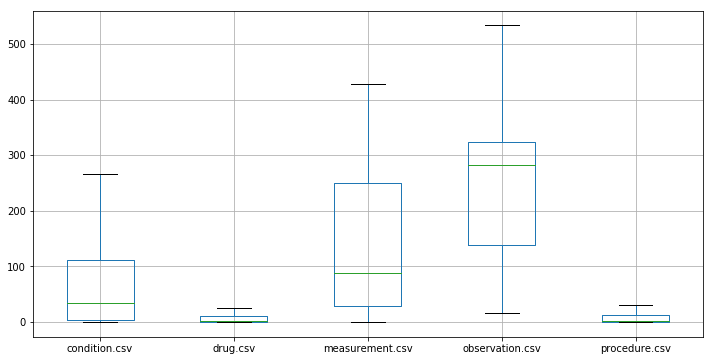

In [11]:
omop_category_counts_df = aou_analysis.omop_plot_category_counts(omop_patients, csvs)
aou_analysis.export_df(omop_category_counts_df, 'export/omop_category_counts.csv')
display(omop_category_counts_df.boxplot(figsize=(12,6), showfliers=False))

*OMOP data comes in csv rows. This chart shows the number of entries per patient. The number of patients with no entires drops the average significantly in some cases.*

### 2 b: Count of standardized code *systems* for each OMOP data type.
OMOP code systems are an enumerated set of names. Each table has a different set of columns that define where there system is located, defined in `aou_analysis.CODE_COLUMNS`.

In [12]:
aou_analysis.concept_table.reset_index(inplace=True)
aou_analysis.concept_table.set_index(['concept_id', 'concept_code', 'vocabulary_id'], inplace=True)
system_counts = aou_analysis.omop_system_counts(omop_patients)
omop_system_df = pd.DataFrame(system_counts).transpose()
aou_analysis.export_df(omop_system_df, 'export/omop_system_counts.csv')
display(omop_system_df)

CPT4  ICD9Proc    LOINC    None      PPI  RxNorm  SNOMED
condition.csv      NaN       NaN      NaN   133.0      NaN     NaN  9365.0
drug.csv           NaN       NaN      NaN  2945.0      NaN    97.0     NaN
measurement.csv    NaN       NaN  12146.0   974.0    427.0     NaN    19.0
observation.csv    NaN       NaN   2855.0  2309.0  12140.0     NaN  1647.0
procedure.csv    569.0      49.0      NaN    59.0      NaN     NaN   443.0

*Currently many rows don't specify a system, which is why the `None` has so many results.*

### 2 c: Top N standardized codes for each data category.
`aou_analysis.omop_coding_counts` counts pairs of ids, based on the type of table. `vocab` is a dictionary of lookups between an id pair and the `vocabulary.csv` table of definitions.

In [13]:
coding_counts, vocab = aou_analysis.omop_coding_counts(omop_patients)
vocab_df = aou_analysis.compose_vocab_df(vocab)

for name, counter in coding_counts.items():
    df = pd.DataFrame(counter.most_common())
    df.set_index([0], inplace=True)
    df.rename(columns={1: 'count'}, inplace=True)
    df.index.name = name
    new_df = df.join(vocab_df)
    aou_analysis.export_df(new_df, 'export/omop_'+name.split('.')[0]+'coding_counts.csv')
    display(new_df)

count                                                                  concept_name  \
condition.csv                                                                                            
78097 45552285       166                                          Secondary malignant neoplasm of bone   
320128 35207668      148                                                        Essential hypertension   
4163261 35206266     133                                                   Malignant tumor of prostate   
42872402 45586572    128                                    Coronary arteriosclerosis in native artery   
4157332 45556996     120                                           Malignant neoplasm of female breast   
137809 45556996      120                                   Primary malignant neoplasm of female breast   
137809 44824029      111                                   Primary malignant neoplasm of female breast   
4157332 45600511     108                                           Malignant neoplasm of female breast   
137809 45600511      108                                   Primary malignant neoplasm of female breast   
201254 44820682      106                                                      Type 1 diabetes mellitus   
4141454 45552479     103                               Recurrent major depression in partial remission   
4144111 35208190     100                           Gastroesophageal reflux disease without esophagitis   
4286201 35207139      85                                                      Schizoaffective disorder   
436676 436676         81                                                 Posttraumatic stress disorder   
201254 44821787       72                                                      Type 1 diabetes mellitus   
40484648 44821787     72                                         Type 1 diabetes mellitus uncontrolled   
201826 44836914       71                                                      Type 2 diabetes mellitus   
320128 320128         68                                                        Essential hypertension   
442752 44831524       68                                                                   Muscle pain   
435216 35206878       64                                      Disorder due to type 1 diabetes mellitus   
4193704 35206882      62                                 Type 2 diabetes mellitus without complication   
40405599 35209011     58                                                                  Fibromyalgia   
434613 434613         55                                                  Generalized anxiety disorder   
318800 44822019       55                                               Gastroesophageal reflux disease   
256439 256439         52                                               Allergic rhinitis due to pollen   
4077577 4077577       51                                           Moderate recurrent major depression   
252936 443558         49                                              Allergic rhinitis due to animals   
137820 35207108       49                                                  Postoperative hypothyroidism   
320128 44821949       46                                                        Essential hypertension   
192568 44821737       46                   Secondary malignant neoplasm of intra-abdominal lymph nodes   
40481919 44835932     46                                                      Coronary atherosclerosis   
440383 44833421       45                                                           Depressive disorder   
134736 44825708       45                                                                      Backache   
433716 44829816       43                                          Primary malignant neoplasm of testis   
432883 4077577        40                                 Recurrent major depressive episodes, moderate   
81250 44819488        39                                                   Carcinoma in situ of b

count                                                                                                             concept_name  \
drug.csv                                                                                                                                              
0                      112                                                                                                                      NaN   
19122121                80                                                                                                                      NaN   
1308216                 61                                                                                                                      NaN   
1112807                 57                                                                                                                      NaN   
797399                  51                                                                                                                      NaN   
778711                  51                                                                                                                      NaN   
715259                  49                                                                                                                      NaN   
1103314                 47                                                                                                                      NaN   
1539403                 47                                                                                                                      NaN   
948078                  46                                                                                                                      NaN   
1322184                 42                                                                                                                      NaN   
1107830                 42                                                                                                                      NaN   
1361711                 40                                                                                                                      NaN   
766529                  39                                                                                                                      NaN   
1307046                 39                                                                                                                      NaN   
19011773                35                                                                                                                      NaN   
1125315                 35                                                                                                                      NaN   
970250                  31                                                                                                                      NaN   
1501700                 28                                                                                                                      NaN   
19071697                27                                                                                                                      NaN   
1149380                 27                                                                                                                      NaN   
19135832                25                                                                                                                      NaN   
903963                  25                                                                                                                      NaN   
19080217                25                                                                                                                      NaN   
19035704                24                                                                     

count                                                                                                             concept_name  \
measurement.csv                                                                                                                                     
0 0                  974                                                                                                      No matching concept   
3004249 5            850                                                                                                  Systolic blood pressure   
3012888 5            850                                                                                                 Diastolic blood pressure   
3027598 5            850                                                                                                      Mean blood pressure   
3024171 9            662                                                                                                         Respiratory rate   
3013762 14           598                                                                                                     Body weight Measured   
3036277 11           557                                                                                                              Body height   
3020891 6            458                                                                                                         Body temperature   
3022318 1586218      284                                                                                                        Heart rate rhythm   
3004501 3004501      160                                                                                 Glucose [Mass/volume] in Serum or Plasma   
3006906 3006906      160                                                                                 Calcium [Mass/volume] in Serum or Plasma   
3016723 3016723      159                                                                              Creatinine [Mass/volume] in Serum or Plasma   
3013682 3013682      159                                                                           Urea nitrogen [Mass/volume] in Serum or Plasma   
3015632 3015632      157                                                                  Carbon dioxide, total [Moles/volume] in Serum or Plasma   
3014576 3014576      157                                                                               Chloride [Moles/volume] in Serum or Plasma   
3000963 3000963      155                                                                                        Hemoglobin [Mass/volume] in Blood   
3023314 3023314      155                                                                 Hematocrit [Volume Fraction] of Blood by Automated count   
3000905 3000905      155                                                                        Leukocytes [#/volume] in Blood by Automated count   
3020416 3020416      155                                                                      Erythrocytes [#/volume] in Blood by Automated count   
3019897 3019897      155                                                                Erythrocyte distribution width [Ratio] by Automated count   
3023599 3023599      155                                                                                  MCV [Entitic volume] by Automated count   
3012030 3012030      155                                                                                    MCH [Entitic mass] by Automated count   
3009744 3009744      155                                                                                    MCHC [Mass/volume] by Automated count   
3020630 3020630      151                                                                                 Protein [Mass/volume] in Serum or Plasma   
3013721 3013721      150                                                Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma

count                                                                                                             concept_name  \
observation.csv                                                                                                                                     
0 0                 2133                                                                                                      No matching concept   
4041306 0            647                                                                                                 Tobacco use and exposure   
4144272 5            377                                                                                                     Never smoked tobacco   
1586155 1586155      144                                                                                                    White: White Specific   
1585636 1585636      129                                                                                  Recreational Drug Use: Which Drugs Used   
44817220 1585252     124                                                                                                    Reporter phone number   
3043579 1585250      124                                                                                                      ZIP Code [Location]   
40766228 1585248     124                                                                                                     Current city [PhenX]   
3042942 1585596      124                                                                                                               First name   
3046810 1585598      124                                                                                                                Last name   
1585246 1585246      124                                                                                              PII Address: Street Address   
3022007 1585259      124                                                                                                               Birth date   
40766229 1585249     124                                                                                                    Current state [PhenX]   
46234749 1585260     122                                                                                                    Patient Email address   
1384430 1384430      121                                                                                                  Other: Other Conditions   
3042530 1585597      115                                                                                                              Middle name   
43528759 43528759    112                                                                                Hearing Vision: Hearing Vision Conditions   
1384390 1384390       86                                                                                   Digestive: Digestive System Conditions   
40771090 1585952      79                                                                                     Current occupational status [SAMHSA]   
1384662 1384662       78                                                                        Infectious Diseases: Infectious Disease Condition   
4310250 4             77                                                                                                                Ex-smoker   
1585838 1585838       76                                                                                                  Gender: Gender Identity   
1586140 1586140       75                                                                                                Race: What Race Ethnicity   
1586099 1586099       75                                                                                      EHR Consent PII: Consent Permission   
4214956 1384522       74                                                                                   History of clinical finding in subject

count                                                                            concept_name  \
procedure.csv                                                                                                      
2108115 2108115       70                                                                                           
4036803 45552054      58                                                          General examination of patient   
4145333 44826243      47                                                                Adult health examination   
4077697 44836711      37                                                                   Screening mammography   
4132855 35225097      28                                                                            Immunization   
4147961 45542403      27                                              Screening for malignant neoplasm of breast   
4029715 35225154      27                                                  Radiation oncology AND/OR radiotherapy   
4205728 44828568      26                                                  Radiation therapy procedure or service   
2213283 2213283       25                                                                                           
2211826 2211826       25                                                                                           
4063521 35225040      21                                                         Examination of research control   
2785970 2785970       16                                                                                     NaN   
4254477 44828590      15                                                                              Counseling   
2414397 2414397       14                                                                                           
4306780 44830849      14                                                                 Gynecologic examination   
2414398 2414398       13                                                                                           
4062484 44826258      13                                              Screening for malignant neoplasm of cervix   
2211809 2211809       12                                                                                           
2211353 2211353       11                                                                                           
2314284 2314284       10                                                                                           
2314290 2314290       10                                                                                           
2213284 2213284       10                                                                                           
4306780 44828600      10                                                                 Gynecologic examination   
40480674 44821609     10                                                 Preoperative cardiovascular examination   
2211701 2211701        9                                                                                           
4175226 44827420       9                                               Screening for malignant neoplasm of colon   
2786175 2786175        9                                                                                     NaN   
2211491 2211491        8                                                                                           
2211851 2211851        8                                                                                           
2414395 2414395        8                                                                                           
2313869 2313869        8                                                                                           
2313991 2313991        7                                                                                           
40756910 40756910      7                                                   

*Some of these concept and source names are very far apart. More investigation is needed to determine why these don't match up.*

*drug.csv has many NaN values, these look like they're all from nec_phs which doesn't code `drug_source_concept_id` the same way as other sources, which has the majority of drug codings.*

*measurement.csv `0 0 974 No Matching Concept` is all nec_phs values. The units are varied, but no columns show a unique identifier of what is being measured.*

*observation.csv has `0 0 2133 No Matching Concept` which are survey questions based on observation_source_value and value_source_value.*

In [14]:
coding_counts

{'condition.csv': Counter({'4115238 4056713': 1,
          '37018356 435243': 1,
          '4085100 257011': 2,
          '260123 260123': 3,
          '4297799 138102': 1,
          '432883 4077577': 40,
          '4077577 4077577': 51,
          '765131 765131': 3,
          '254761 254761': 7,
          '4263748 4263748': 5,
          '434613 434613': 55,
          '133835 45766714': 8,
          '4323418 4323418': 1,
          '318800 4144111': 2,
          '4113650 35209447': 1,
          '75909 45567753': 4,
          '77646 45567753': 2,
          '198846 44828059': 1,
          '443601 35209275': 4,
          '80502 44822235': 17,
          '137809 44824029': 111,
          '374313 45566695': 5,
          '80824 44826911': 3,
          '80502 35209038': 36,
          '4157332 45600511': 108,
          '137809 45600511': 108,
          '40483287 35209299': 2,
          '75909 45538999': 1,
          '77646 45538999': 1,
          '40483287 44824345': 1,
          '78473 45592147

### 2 e: For each OMOP column, how often was a value present vs absent? 

In [15]:
omop_data_dump = omop_analyze.data_dump(path=current_directory+omop_directory)
for csv, table in omop_data_dump: 
    table_df = pd.DataFrame(table)
    src_groups = table_df.groupby('src_hpo_id')

    populated = {
        'absent': (table_df == '').sum(axis=0),
        'present': (table_df != '').sum(axis=0), 
    }
    for group in src_groups:
        group_sum = pd.DataFrame(pd.DataFrame(group[1]) != '').sum()
        populated[group[0]] = group_sum
    df = pd.DataFrame(populated)
    df.index.name = csv
    display(df)

['condition.csv', 'drug.csv', 'measurement.csv', 'observation.csv', 'procedure.csv']


absent  present  cpmc_ceders  ipmc_rush  nec_phs
condition.csv                                                                  
                                    0     9498         2707       2219     4572
condition_occurrence_id             0     9498         2707       2219     4572
person_id                           0     9498         2707       2219     4572
condition_concept_id                0     9498         2707       2219     4572
condition_start_date                0     9498         2707       2219     4572
condition_start_datetime            0     9498         2707       2219     4572
condition_end_date               3108     6390            0       2219     4171
condition_end_datetime           7279     2219            0       2219        0
condition_type_concept_id           0     9498         2707       2219     4572
stop_reason                      7279     2219            0       2219        0
provider_id                      9498        0            0          0        0
visit_occurrence_id              2707     6791            0       2219     4572
condition_source_value              0     9498         2707       2219     4572
condition_source_concept_id         0     9498         2707       2219     4572
condition_status_source_value    6875     2623          404       2219        0
condition_status_concept_id         0     9498         2707       2219     4572
src_hpo_id                          0     9498         2707       2219     4572
source_vocabulary                   0     9498         2707       2219     4572
source_code_structured              0     9498         2707       2219     4572

absent  present  cpmc_ceders  ipmc_rush  nec_phs
drug.csv                                                                      
                                   0     3042          736         42     2264
drug_exposure_id                   0     3042          736         42     2264
person_id                          0     3042          736         42     2264
drug_concept_id                    0     3042          736         42     2264
drug_exposure_start_date           0     3042          736         42     2264
drug_exposure_start_datetime       0     3042          736         42     2264
drug_exposure_end_date             0     3042          736         42     2264
drug_exposure_end_datetime       116     2926          620         42     2264
verbatim_end_date               2307      735          695         40        0
drug_type_concept_id               0     3042          736         42     2264
stop_reason                     2399      643          631         12        0
refills                         2911      131           96         35        0
quantity                        2998       44            2         42        0
days_supply                     3042        0            0          0        0
sig                             2299      743          736          7        0
route_concept_id                2264      778          736         42        0
lot_number                      3042        0            0          0        0
provider_id                     3042        0            0          0        0
visit_occurrence_id              736     2306            0         42     2264
drug_source_value                  0     3042          736         42     2264
drug_source_concept_id          2264      778          736         42        0
route_source_value              2342      700          658         42        0
dose_unit_source_value           736     2306          625         39     1642
src_hpo_id                         0     3042          736         42     2264
source_vocabulary               2941      101           59         42        0
source_code_structured          2941      101           59         42        0

absent  present  cpmc_ceders  ipmc_rush  nec_phs   rdr
measurement.csv                                                                      
                                    0    13566         3720       6715     1069  2062
measurement_id                      0    13566         3720       6715     1069  2062
person_id                           0    13566         3720       6715     1069  2062
measurement_concept_id              0    13566         3720       6715     1069  2062
measurement_date                    0    13566         3720       6715     1069  2062
measurement_datetime                0    13566         3720       6715     1069  2062
measurement_type_concept_id         0    13566         3720       6715     1069  2062
operator_concept_id                19    13547         3720       6715     1050  2062
value_as_number                   785    12781         3687       6689      918  1487
value_as_concept_id                19    13547         3720       6715     1050  2062
unit_concept_id                   472    13094         3267       6715     1050  2062
range_low                        4639     8927         2405       6522        0     0
range_high                       4639     8927         2405       6522        0     0
provider_id                     13566        0            0          0        0     0
visit_occurrence_id              3720     9846            0       6715     1069  2062
measurement_source_value          974    12592         3720       6715       95  2062
measurement_source_concept_id       0    13566         3720       6715     1069  2062
unit_source_value                1347    12219         3267       6597      868  1487
value_source_value                451    13115         3687       6712      944  1772
src_hpo_id                          0    13566         3720       6715     1069  2062
source_vocabulary                   0    13566         3720       6715     1069  2062
source_code_structured              0    13566         3720       6715     1069  2062

absent  present  cpmc_ceders  ipmc_rush  nec_phs    rdr
observation.csv                                                                       
                                    0    18951          647        568      395  17341
observation_id                      0    18951          647        568      395  17341
person_id                           0    18951          647        568      395  17341
observation_concept_id              0    18951          647        568      395  17341
observation_date                    0    18951          647        568      395  17341
observation_datetime                0    18951          647        568      395  17341
observation_type_concept_id         0    18951          647        568      395  17341
value_as_number                 18587      364           58          0        0    306
value_as_string                 15126     3825          589        464        0   2772
value_as_concept_id               380    18571          647        568       15  17341
qualifier_concept_id             1138    17813            0        472        0  17341
unit_concept_id                  1138    17813            0        472        0  17341
provider_id                     18951        0            0          0        0      0
visit_occurrence_id             18086      865            0        472      380     13
observation_source_value            0    18951          647        568      395  17341
observation_source_concept_id       0    18951          647        568      395  17341
unit_source_value               18951        0            0          0        0      0
qualifier_source_value          18951        0            0          0        0      0
value_source_concept_id          1610    17341            0          0        0  17341
value_source_value               1610    17341            0          0        0  17341
questionnaire_response_id        1627    17324            0          0        0  17324
src_hpo_id                          0    18951          647        568      395  17341
source_vocabulary                  32    18919          647        536      395  17341
source_code_structured             32    18919          647        536      395  17341

absent  present  cpmc_ceders  ipmc_rush  nec_phs
procedure.csv                                                                
                                  0     1120          609         51      460
procedure_occurrence_id           0     1120          609         51      460
person_id                         0     1120          609         51      460
procedure_concept_id              0     1120          609         51      460
procedure_date                    0     1120          609         51      460
procedure_datetime                0     1120          609         51      460
procedure_type_concept_id         0     1120          609         51      460
modifier_concept_id             520      600           89         51      460
quantity                        460      660          609         51        0
provider_id                    1120        0            0          0        0
visit_occurrence_id             609      511            0         51      460
procedure_source_value           91     1029          518         51      460
procedure_source_concept_id       0     1120          609         51      460
qualifier_source_value         1110       10            0         10        0
src_hpo_id                        0     1120          609         51      460
source_vocabulary                 0     1120          609         51      460
source_code_structured            0     1120          609         51      460

### 2 f: For each OMOP column representing a status flag, what is the distribution of values? 

In [16]:
omop_status_flags = [
    'stop_reason',
    'source_vocabulary',
    'src_hpo_id',
    'condition_status_concept_id',
    'unit_source_value',
    'observation_source_value',
]
omop_counts = aou_analysis.omop_status_counts(omop_data_dump, omop_status_flags)
for table, counters in omop_counts.items():
    print(table)
    for name, counter in counters.items():
        df = pd.DataFrame(counter.most_common())
        df.index.name = name
        display(df)

condition.csv


0     1
stop_reason                  
0                        7279
1            Discharged  2219

0     1
source_vocabulary               
0                  ICD10CM  4613
1                   ICD9CM  2666
2                   SNOMED  2219

0     1
src_hpo_id                   
0               nec_phs  4572
1           cpmc_ceders  2707
2             ipmc_rush  2219

0  \
condition_status_concept_id                                                                                                                            
0                                                                                                       No matching concept None No matching concept   
1                                                                                                                148006 SNOMED Preliminary diagnosis   
2                                                                                                                52870002 SNOMED Admitting diagnosis   
3                                              250.03 ICD9CM Diabetes mellitus without mention of complication, type I [juvenile type], uncontrolled   
4                                                                                                         C61 ICD10CM Malignant neoplasm of prostate   
5                                                                                                       I10 ICD10CM Essential (primary) hypertension   
6                                                     I25.10 ICD10CM Atherosclerotic heart disease of native coronary artery without angina pectoris   
7                                250.01 ICD9CM Diabetes mellitus without mention of complication, type I [juvenile type], not stated as uncontrolled   
8                                                                          F33.41 ICD10CM Major depressive disorder, recurrent, in partial remission   
9                                                                                                F25.9 ICD10CM Schizoaffective disorder, unspecified   
10                                                                                K21.9 ICD10CM Gastro-esophageal reflux disease without esophagitis   
11                                                                                                    729.1 ICD9CM Myalgia and myositis, unspecified   
12                                                                             E10.8 ICD10CM Type 1 diabetes mellitus with unspecified complications   
13                                                                                                                        M79.7 ICD10CM Fibromyalgia   
14                                                                                                       E89.0 ICD10CM Postprocedural hypothyroidism   
15                           250.00 ICD9CM Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontro...   
16                                                          196.2 ICD9CM Secondary and unspecified malignant neoplasm of intra-abdominal lymph nodes   
17                                                             414.00 ICD9CM Coronary atherosclerosis of unspecified type of vessel, native or graft   
18                                                                                          311 ICD9CM Depressive disorder, not elsewhere classified   
19                                                                                   186.9 ICD9CM Malignant neoplasm of other and unspecified testis   
20                                                                                                                   530.81 ICD9CM Esophageal reflux   
21                                                                                                            M25.511 ICD10CM Pain in right shoulder   
22                                                                                      E11.9 ICD10CM Type 2 diabetes mellitus without complications   
23                                                                                                                724.5 ICD9CM Backache, unspecified   
24                                                                                                        257.2 ICD9CM Other testicular hypofunction   
25                                         

drug.csv


0     1
stop_reason                            
0                                  2399
1               Patient Discharge   485
2                Patient Transfer    57
3                         Reorder    41
4               Therapy Completed    34
5              Patient Discharged     7
6               Therapy completed     4
7                           Error     4
8                 Duplicate Order     3
9              Patient Preference     3
10                Dose Adjustment     2
11           Med List Update Util     1
12           Change in dosage for     1
13            Alternative Therapy     1

0     1
source_vocabulary                        
0                                    2941
1                            RxNorm    48
2                            SNOMED    43
3                  RxNorm Extension     6
4                         GCN_SEQNO     2
5                              MeSH     2

0     1
src_hpo_id                   
0               nec_phs  2264
1           cpmc_ceders   736
2             ipmc_rush    42

measurement.csv


0     1
source_vocabulary               
0                    LOINC  5686
1                   Domain  4825
2                      PPI  2062
3                     None   974
4                   ICD9CM    11
5                  ICD10CM     8

0     1
src_hpo_id                   
0             ipmc_rush  6715
1           cpmc_ceders  3720
2                   rdr  2062
3               nec_phs  1069

0     1
unit_source_value                             
0                                      0  4825
1                                         1347
2                                  mg/dL   948
3                                   g/dL   659
4                                      %   650
5                                 mmol/L   610
6                                 mm[Hg]   568
7                                     cm   493
8                                    U/L   417
9                                10*3/uL   398
10                                     @   290
11                                  /min   284
12                                    fL   235
13                                 kg/m2   199
14                 millimeter of mercury   156
15                                    pg   155
16                                Pounds   128
17                                  K/uL   122
18                               10*6/uL    80
19                                 pound    76
20                                    kg    71
21                            [arb'U]/mL    70
22                                 ng/mL    69
23                                  M/uL    60
24                                 ratio    57
25                                  inch    49
26                               {ratio}    48
27                                (calc)    42
28                                Inches    41
29                                /[HPF]    36
30                           Thousand/uL    30
31                               {titer}    27
32                               [IU]/mL    24
33                                  [pH]    23
34                                     s    22
35                      mL/min/{1.73_m2}    22
36                           g/dL (calc)    21
37                         mL/min/1.73m2    21
38                                 pg/mL    20
39                          mg/mg{creat}    20
40                               m[IU]/L    18
41                                   g/L    16
42                            Million/uL    15
43                                 {INR}    12
44                                 ug/dL     9
45                                 mEq/L     9
46                                  mm/h     8
47                                  mg/L     7
48                           {index_val}     7
49                                  ug/L     6
50                             mg/(24.h)     6
51                                  IU/L     6
52                           mmol/(24.h)     5
53                                 ng/dL     5
54                              m[IU]/mL     5
55                              g/(24.h)     3
56                                /[LPF]     3
57                           {Index_val}     2
58                                     L     2
59                           mg/g{creat}     2
60                               [APL'U]     1
61                                nmol/L     1
62                                     g     1
63                                 ug/mL     1
64                               mosm/kg     1
65                        {Ehrlich'U}/dL     1
66                      nmol/mmol{creat}     1

observation.csv


0      1
source_vocabulary                      
0                            PPI  15208
1                           None   2780
2                         Domain    535
3                         ICD9CM    207
4                        ICD10CM    173
5                                    32
6                           Race     15
7                  Concept Class      1

0      1
src_hpo_id                    
0                   rdr  17341
1           cpmc_ceders    647
2             ipmc_rush    568
3               nec_phs    395

0      1
unit_source_value         
0                    18951

0    1
observation_source_value                                                         
0                                                             5:Never Smoker  377
1                                                        White_WhiteSpecific  144
2                                         RecreationalDrugUse_WhichDrugsUsed  129
3                                                PIIContactInformation_Phone  124
4                                                       StreetAddress_PIIZIP  124
5                                                      StreetAddress_PIICity  124
6                                                              PIIName_First  124
7                                                               PIIName_Last  124
8                                                   PIIAddress_StreetAddress  124
9                                              PIIBirthInformation_BirthDate  124
10                                                    StreetAddress_PIIState  124
11                                                   ConsentPII_EmailAddress  122
12                                                     Other_OtherConditions  121
13                                                            PIIName_Middle  115
14                                     HearingVision_HearingVisionConditions  112
15                        DiagnosedHealthCondition_GrandparentCirculatoryCon  104
16                                       Digestive_DigestiveSystemConditions   86
17                        DiagnosedHealthCondition_MotherCirculatoryConditio   82
18                                                              bp_diastolic   80
19                                                               bp_systolic   80
20                                                                    weight   79
21                                               Employment_EmploymentStatus   79
22                             InfectiousDiseases_InfectiousDiseaseCondition   78
23                        DiagnosedHealthCondition_FatherCirculatoryConditio   78
24                                                           4:Former Smoker   77
25                                                                       BMI   76
26                                                     Gender_GenderIdentity   76
27                                                    Race_WhatRaceEthnicity   75
28                                           EHRConsentPII_ConsentPermission   75
29                                         Circulatory_CirculatoryConditions   74
30                                      NervousSystem_NervousSystemCondition   74
31                                                   ExtraConsent_TodaysDate   74
32                                                      TheBasics_Birthplace   73
33                                              OverallHealth_GeneralQuality   73
34                                               OverallHealth_GeneralHealth   73
35                                                       Income_AnnualIncome   73
36                                       OverallHealth_GeneralPhysicalHealth   73
37                                        MaritalStatus_CurrentMaritalStatus   73
38                                                    HomeOwn_CurrentHomeOwn   73
39                                               EducationLevel_HighestGrade   73
40                                    OverallHealth_HealthMaterialAssistance   73
41                                          OverallHealth_SocialSatisfaction   73
42                                         OverallHealth_GeneralMentalHealth   73
43                                          OverallHealth_EverydayActivities   73
44                                        LivingSituation_HowManyLivingYears   73
45                                       OverallHealth_EmotionalProblem7Days   73
46                                           BiologicalSexAtBirth_SexAtBirth   73
47                                               TheBasic

procedure.csv


0    1
source_vocabulary               
0                      CPT4  569
1                    ICD9CM  225
2                   ICD10CM  218
3                  ICD10PCS   59
4                  ICD9Proc   49

0    1
src_hpo_id                  
0           cpmc_ceders  609
1               nec_phs  460
2             ipmc_rush   51

```condition_status_concept_id``` *seems to have concepts, not statuses.*

## OMOP Anomolies
* Measurement
  * measurement_concept_id is missing on 975 nec_phs measurements. There's no way to determine what these are measurements are of.

* Condition
  * `condition_status_concept_id` seems to have concepts (copying `condition_concept_id`) not statuses.
  * cpmc_ceders has no condition_end_date or condition_end_datetime, ipmc_rush has both, and nec_phs only uses condition_end_date. There's no consistency.


# 3: Comparison of OMOP and FHIR data


### 3 a: For each participant, count the total number of S4S and OMOP entries.
The patient ids were used to align the data, then sorted by S4S entries, then the patient ids were removed.

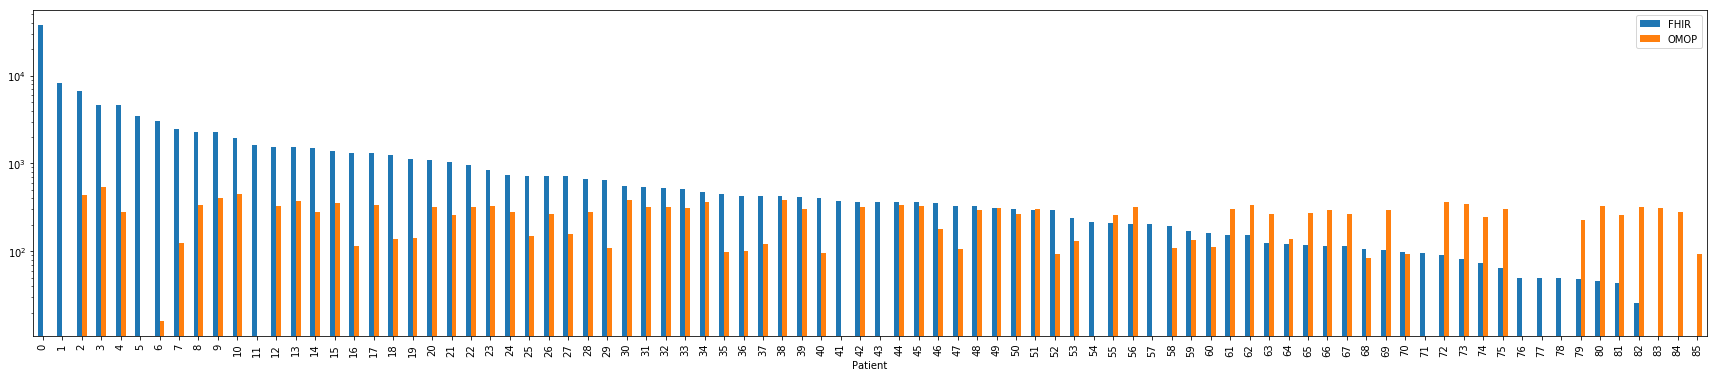

In [17]:
compare_df = aou_analysis.compare_per_patient(fhir_patients, omop_patients)
compare_df.plot.bar(figsize=(30,6), logy=True)

*Note that the y-axis is logarithmic. I was surprised that there doesn't look to be much correlation between number of S4S entries and number of OMOP entries. Further digging into similar types of entires instead of compiled entries could yield more detail*

### 3 b: For each participant, compare the number of FHIR medication orders and statements to the number of OMOP drug entries

Entries of medication statements and medication orders were combined, then compared based on patient_ids.

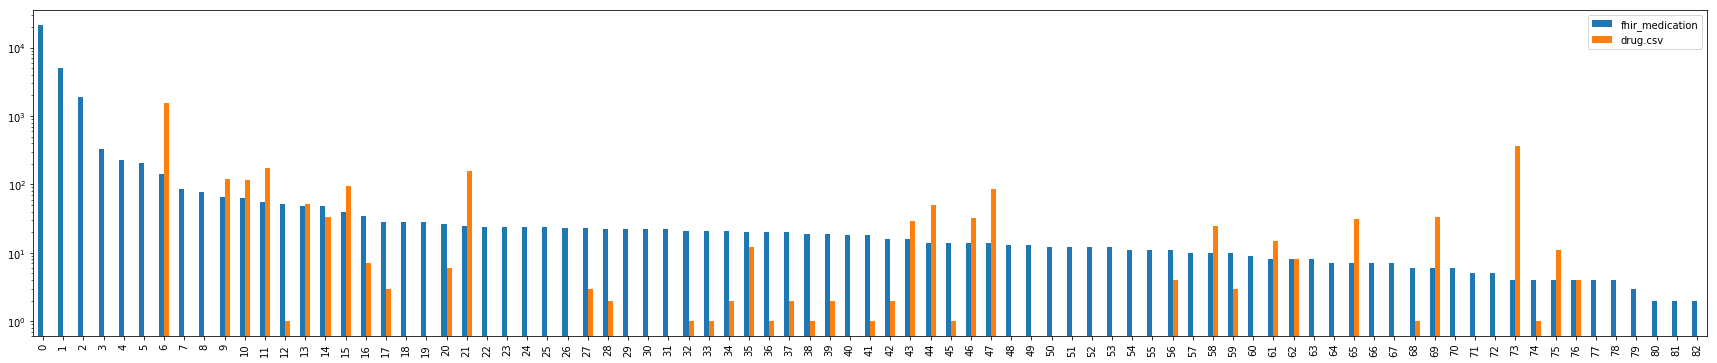

In [18]:
drug_df = aou_analysis.compare_medication_per_patient(fhir_patients, omop_patients)
drug_df.plot.bar(figsize=(30,6), logy=True)

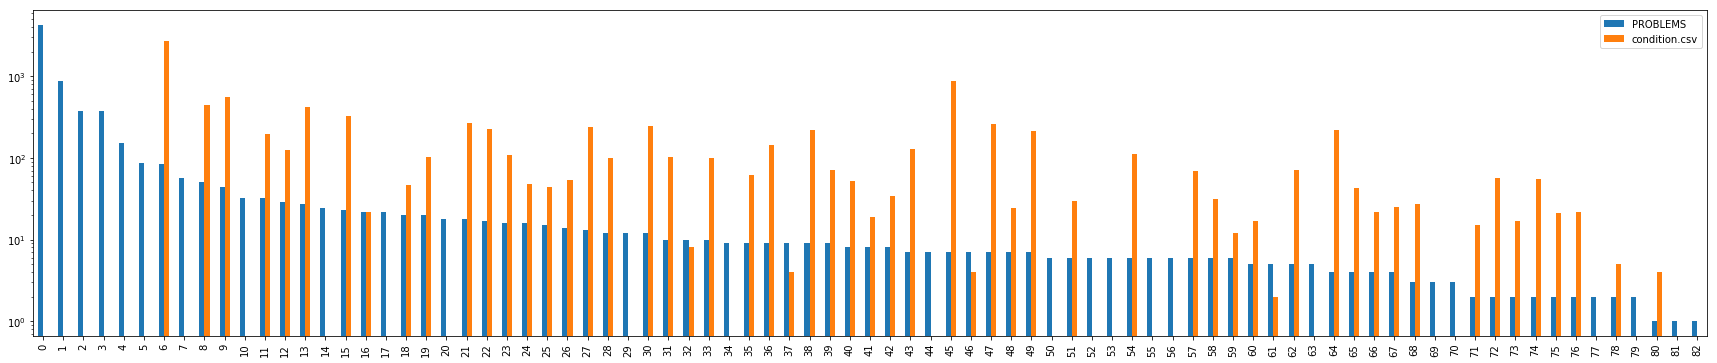

In [19]:
condition_df = aou_analysis.compare_condition_per_patient(fhir_patients, omop_patients)
condition_df.plot.bar(figsize=(30,6), logy=True)

*both of these comparisons are not exact matches, but it's impressive to see how low the correlation between FHIR and OMOP categories.*